<a href="https://colab.research.google.com/github/saman-nia/tasks/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.1 Import necessary libraries:

In [1]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, logging as hf_logging
import matplotlib.pyplot as plt
import logging
import warnings
import re

In [2]:
# I turned off all warnings from pandas, transformers, and other libraries to show the results cleaned.
warnings.filterwarnings('ignore')

# I also avoid most logs
logging.basicConfig(level=logging.ERROR)
hf_logging.set_verbosity_error()

In [3]:
""" Load the dataset. I could do it with 'from llama_index.core import SimpleDirectoryReader'
    but since I load the data from my Github, Pandas would be better as the SimpleDirectoryReader reads from local directory """

url = 'https://raw.githubusercontent.com/saman-nia/tasks/main/pinterest-fashion-dataset.csv'
data = pd.read_csv(url)
data['price in $'] = pd.to_numeric(data['price in $'], errors='coerce').fillna(0)
data.fillna({'ratings': data['ratings'].mean()}, inplace=True)

# I convert the 'price in $' column to numeric, then I forced errors to NaN and filled with 0.
data['price in $'] = pd.to_numeric(data['price in $'], errors='coerce')

For this task, I chose to use GPT-2 because of its easy integration in generating text, which aligns perfectly with the project's requirements for natural language response generation. While LlamaIndex and LangChain offer strong features, they require API access and more complex setup, which could complicate the project unnecessarily. GPT-2 has availability without the need for API keys made it the optimal choice, and it allowing me to focus on showing my text generation skills effectively. However, I have explored both LlamaIndex and LangChain to understand their application in real-world projects where their advanced retrieval and language processing capabilities would be essential. In my last experience, I had chance to use LangChain and I think it would not be a deal for me to use it in a real project.

In [4]:
# I used the pre-trained GPT-2 tokenizer and model.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Here I check and set the pad token for the tokenizer, and if not, the I set it
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

2.2 Define Retrieval Function:

In [5]:
def retrieve_products(query):
    # Retrieves products based on a user's text query with more flexible category matching.
    category_match = re.search(r"best (.+?) under", query, re.IGNORECASE)
    price_limit_match = re.search(r"under (\d+)", query, re.IGNORECASE)

    if category_match and price_limit_match:
        category_query = category_match.group(1)
        price_limit = int(price_limit_match.group(1))

        # Attempt to find a category in the dataset that contains any part of the query category string
        possible_categories = [cat for cat in data['category'].unique() if category_query.lower() in cat.lower()]
        print("Possible Categories:", possible_categories)  # Debug output to see what is being matched

        if not possible_categories:
            return "No matching categories found. Please refine your category description."

        filtered_data = data[
            data['category'].isin(possible_categories) &
            (data['price in $'] <= price_limit)
        ]

        if not filtered_data.empty:
            return filtered_data.sort_values(by='ratings', ascending=False).head(5)
        else:
            return "No products found matching your criteria within the price range."
    else:
        return "Invalid query. Please specify a category and a price limit."

2.3 RAG System with Product Recommendation:

In [6]:
def generate_text(prompt):
    # Generates text using GPT-2 based on the provided prompt.
    inputs = tokenizer.encode_plus(
        prompt,
        return_tensors="pt",
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Generate text ensuring the output is controlled and concise
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=input_ids.shape[1] + 50,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.7,
        top_p=0.9
    )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text.split('. ')[0] + '.'  # Return the first sentence only for clarity

In [7]:
def recommend_products(age, gender, location, interest):
    # Enhances product recommendations with detailed justifications.
    # Adjusting the age range for more flexible filtering
    age_tolerance = 7
    filtered = data[
        (data['image_description'].str.contains(interest, case=False)) &
        (data['age'].between(age - age_tolerance, age + age_tolerance)) &
        (data['gender'].str.lower() == gender.lower())
    ]

    if not filtered.empty:
        # Sorting to find the best-rated and affordable products
        top_rated = filtered.sort_values(by=['ratings', 'price in $'], ascending=[False, True]).head(5)
        product = top_rated.iloc[0]
        prompt = (
            f"Based on your interests in {product['category']} and considering your location in {location}, "
            f"we recommend {product['brand']} because it has a high rating of {product['ratings']} stars "
            f"and is priced at just ${product['price in $']:.2f}, fitting well within your budget."
        )
        response = generate_text(prompt)
        return response
    else:
        return "We couldn't find products that match your preferences. Please try adjusting your filters."

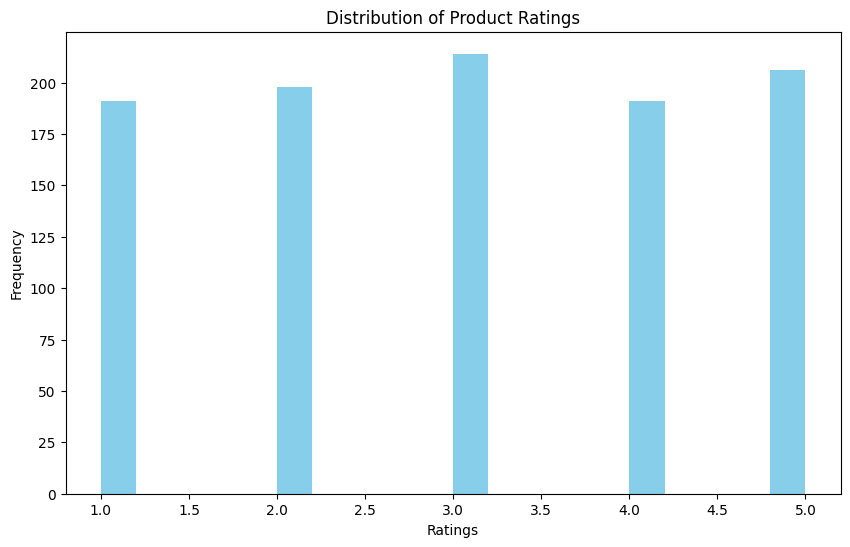

In [8]:
# Visualization to show insights into product ratings
plt.figure(figsize=(10, 6))
data['ratings'].hist(bins=20, color='skyblue')
plt.title('Distribution of Product Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

Here are the categories in the datasets:

'Shoes' 'Shirts & Tops' 'Coats & Jackets' 'Shorts' 'Pants' 'Sunglasses' 'Handbags, Wallets & Cases' 'Skirts' 'Necklaces' 'Earrings'

In [9]:
# Show retrieval
query_result = retrieve_products("best shirts under 100")
print(query_result)

Possible Categories: ['Shirts & Tops']
      user_name  age  gender     location       category       brand  \
522  Customer_3   37  Female     Goulburn  Shirts & Tops        Puma   
203  Customer_4   79    Male  Wagga Wagga  Shirts & Tops        Puma   
128  Customer_9   26    Male      Bunbury  Shirts & Tops       Guess   
306  Customer_7   68  Female     Goulburn  Shirts & Tops        Puma   
135  Customer_6   38    Male        Perth  Shirts & Tops  Forever 21   

     price in $  click_rate  availability  ratings  \
522       26.75         237     Available        5   
203       37.25         254  Out of Stock        5   
128       24.00         396     Available        5   
306       34.50         436  Out of Stock        5   
135       29.70         344     Available        5   

                                             image_url  \
522  http://i.pinimg.com/400x/83/48/23/834823c96792...   
203  http://i.pinimg.com/400x/88/f3/73/88f373a551f7...   
128  http://i.pinimg.com/400x

In [10]:
# Show recommendation
demographic_result = recommend_products(35, "female", "California", "Shoes")
print(demographic_result)

Based on your interests in Shoes and considering your location in California, we recommend Converse because it has a high rating of 5 stars and is priced at just $49.50, fitting well within your budget.


In [11]:
# Show recommendation
demographic_result = recommend_products(55, "male", "California", "Sunglasses")
print(demographic_result)

Based on your interests in Sunglasses and considering your location in California, we recommend Burberry because it has a high rating of 5 stars and is priced at just $87.50, fitting well within your budget.
